# MSXV - FSGP & ASC '24 - Strategy
by Kostubh Agarwal & Rodrigo Tiscareno

## About

The objective(s) of ASC are the following:

1. To complete the American Solar Challenge base route without trailering.
2. To complete as many official miles as possible. (1st Tiebreaker)
3. To complete the distance in the shortest elapsed time. (2nd Tiebreaker)

To sucessfully complete these objectives one must design a good solar car and a good race strategy. Race strategy comes down to a single question:

### **What speed should one drive at?**

The code below uses route data, elevation data, weather data, and solar irradiance data to help predict the performance of the car for various velocities.

## Database

| Route Name                       | Symbol |
|----------------------------------|--------|
| Nashville to Paducah             | 1A     |
| Paducah to Edwardsville          | 1B     |
| Edwardsville to Jefferson City   | 2C     |
| Jefferson City to Independence   | 2D     |
| Independence to Saint Joseph     | 2E     |
| Saint Joseph to Beatrice         | 3F     |
| Beatrice to Kearney              | 3G     |
| Kearney to Gering                | 3H     |
| Gering to Casper                 | 4J     |

To initialize/update database change the **stage_symbol** based on the table above.

In [16]:
from db_funcs import connect_to_db
from db_funcs import fetch_data

connection = connect_to_db()

CONFIGURATION = dict(
    connection = connection,
    stage_symbol = '1A',
    replace_existing = True # Set to True if existing data should be refreshed, False otherwise -- recommended True
)

# %%capture

from irradiance import main as get_irradiance_data
get_irradiance_data(
    connection=CONFIGURATION['connection'],
    stage_symbol= CONFIGURATION['stage_symbol'],
    replace_existing = CONFIGURATION['replace_existing']
)

query = f"SELECT * FROM irradiance where LEFT(route_model_id, 2) = '{CONFIGURATION['stage_symbol']}' ORDER BY route_model_id, period_end"

# First 5 row
fetch_data(query).head()

Executing query to fetch route data...
Query executed successfully. Processing data...

    SELECT DISTINCT ON (name, stage_id) name, latitude, longitude, stage_id
    FROM base_route
    WHERE symbol = '1A'
    ORDER BY name, stage_id, id ASC
    
Deleting existing data for stage ID: 1A0
Data deleted successfully.
Deleting existing data for stage ID: 1A1
Data deleted successfully.
Deleting existing data for stage ID: 1A10
Data deleted successfully.
Deleting existing data for stage ID: 1A11
Data deleted successfully.
Deleting existing data for stage ID: 1A12
Data deleted successfully.
Deleting existing data for stage ID: 1A13
Data deleted successfully.
Deleting existing data for stage ID: 1A14
Data deleted successfully.
Deleting existing data for stage ID: 1A15
Data deleted successfully.
Deleting existing data for stage ID: 1A16
Data deleted successfully.
Deleting existing data for stage ID: 1A17
Data deleted successfully.
Deleting existing data for stage ID: 1A18
Data deleted successf

,id,air_temp,ghi,period_end,period,route_model_id,gti,clearsky_ghi,clearsky_gti,dewpoint_temp,precipitation_rate,relative_humidity,wind_direction_10m,wind_speed_10m,data_type
0,47425,27,0,2024-06-30 03:30:00,0 days 00:30:00,1A0,0,0,0,22.8,0.1,78.4,285,1.4,live
1,47424,26,0,2024-06-30 04:00:00,0 days 00:30:00,1A0,0,0,0,22.9,0.1,80.5,283,1.4,live
2,47423,26,0,2024-06-30 04:30:00,0 days 00:30:00,1A0,0,0,0,23.0,0.7,83.1,287,1.4,live
3,47422,26,0,2024-06-30 05:00:00,0 days 00:30:00,1A0,0,0,0,23.1,0.7,86.1,299,1.3,live
4,47421,25,0,2024-06-30 05:30:00,0 days 00:30:00,1A0,0,0,0,23.2,0.9,88.8,300,1.2,live


## Stage Overview
- Distance
- Weather
- Elevation
    - Instantaneous
    - Total
- Irradiance
    - Instantaneous
    - Total

## Solver

Run the following code to simulate the car over the course of a stage/day at varying velocities. 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from db_funcs import connect_to_db, map_distance_to_id, map_distance_to_irradiance, load_data_to_memory
import math
from tqdm import tqdm

# Properties
m = 300  # mass (kg)
g = 9.81  # acceleration due to gravity (m/s^2)
C_r1 = 0.004  # rolling resistance coefficient 1
C_r2 = 0.052  # rolling resistance coefficient 2
C_d = 0.13  # drag coefficient
A_drag = 1.357  # cross-sectional area (m^2)
p = 1.293  # air density (kg/m^3)
n = 0.16  # efficiency of solar panel
A_solar = 4  # area of solar panel (m^2)
bat_capacity = 40*3.63*36 # pack capacity (Wh)

# Power (Out)
def rolling_resistance(v):
    return (m * g * C_r1 + 4 * C_r2 * v) * v

def drag_resistance(v):
    return 0.5 * p * C_d * A_drag * v ** 3

def gradient_resistance(v, theta):
    return m * g * np.sin(np.deg2rad(theta)) * v

# Power (In)
def solar_power(G):
    # G = -1.5e-6 * (t - 10800)**2 + 1000 # arbitrary solar profile, need to replace w/ live forecasting
    return A_solar * G * n

velocities = np.arange(1, 33)
times = np.arange(1, 28800, 900)
output = np.zeros((32,32))
solar_power_values = np.zeros((32,32))
rolling_resistance_values = np.zeros((32,32))
drag_resistance_values = np.zeros((32,32))
gradient_resistance_values = np.zeros((32,32))
capacity_values = np.full((32,32), bat_capacity)
i = 0
j = 0
t = 0

connection = connect_to_db()
total_iterations = len(velocities) * len(times)
pbar = tqdm(total=total_iterations, desc="Simulating....", unit="step")

base_route_df, irradiance_df = load_data_to_memory()

for i, v in enumerate(velocities):
    for j, t in enumerate(times):
        try: 
            d = v*t
            row_df = map_distance_to_id(base_route_df, '1A', d)['elevation'].values[0]
            row_df2 = map_distance_to_id(base_route_df, '1A', d*2)['elevation'].values[0]
            v_wind = map_distance_to_irradiance(irradiance_df, base_route_df, "1A", d, t)['wind_speed_10m'].values[0]*np.cos(np.deg2rad(map_distance_to_id(base_route_df, '1A', d)['car_bearing'].values[0] - map_distance_to_irradiance(irradiance_df, base_route_df, "1A", d, t)['wind_direction_10m'].values[0]))
        except:
            continue
        v_adj = 0
        v_adj = v_wind+v
        theta = math.degrees(math.atan((row_df2-row_df)/d))
        irradiance = map_distance_to_irradiance(irradiance_df, base_route_df, "1A", d, t)['gti'].values[0]
        solar_power_values[i, j] = solar_power(irradiance)
        rolling_resistance_values[i, j] = rolling_resistance(v)
        drag_resistance_values[i, j] = drag_resistance(v_adj)
        gradient_resistance_values[i, j] = gradient_resistance(v, theta)
        pbar.update(1)
pbar.close()

energy_consumed = - solar_power_values + rolling_resistance_values + drag_resistance_values + gradient_resistance_values # watt-hours

for j in range(1, 32):
    capacity_values[:, j] = capacity_values[:, j-1] - energy_consumed[:, j-1]

Simulating....: 100%|██████████| 1024/1024 [01:26<00:00, 11.80step/s]


## Data Visualizations

### Velocity Selection

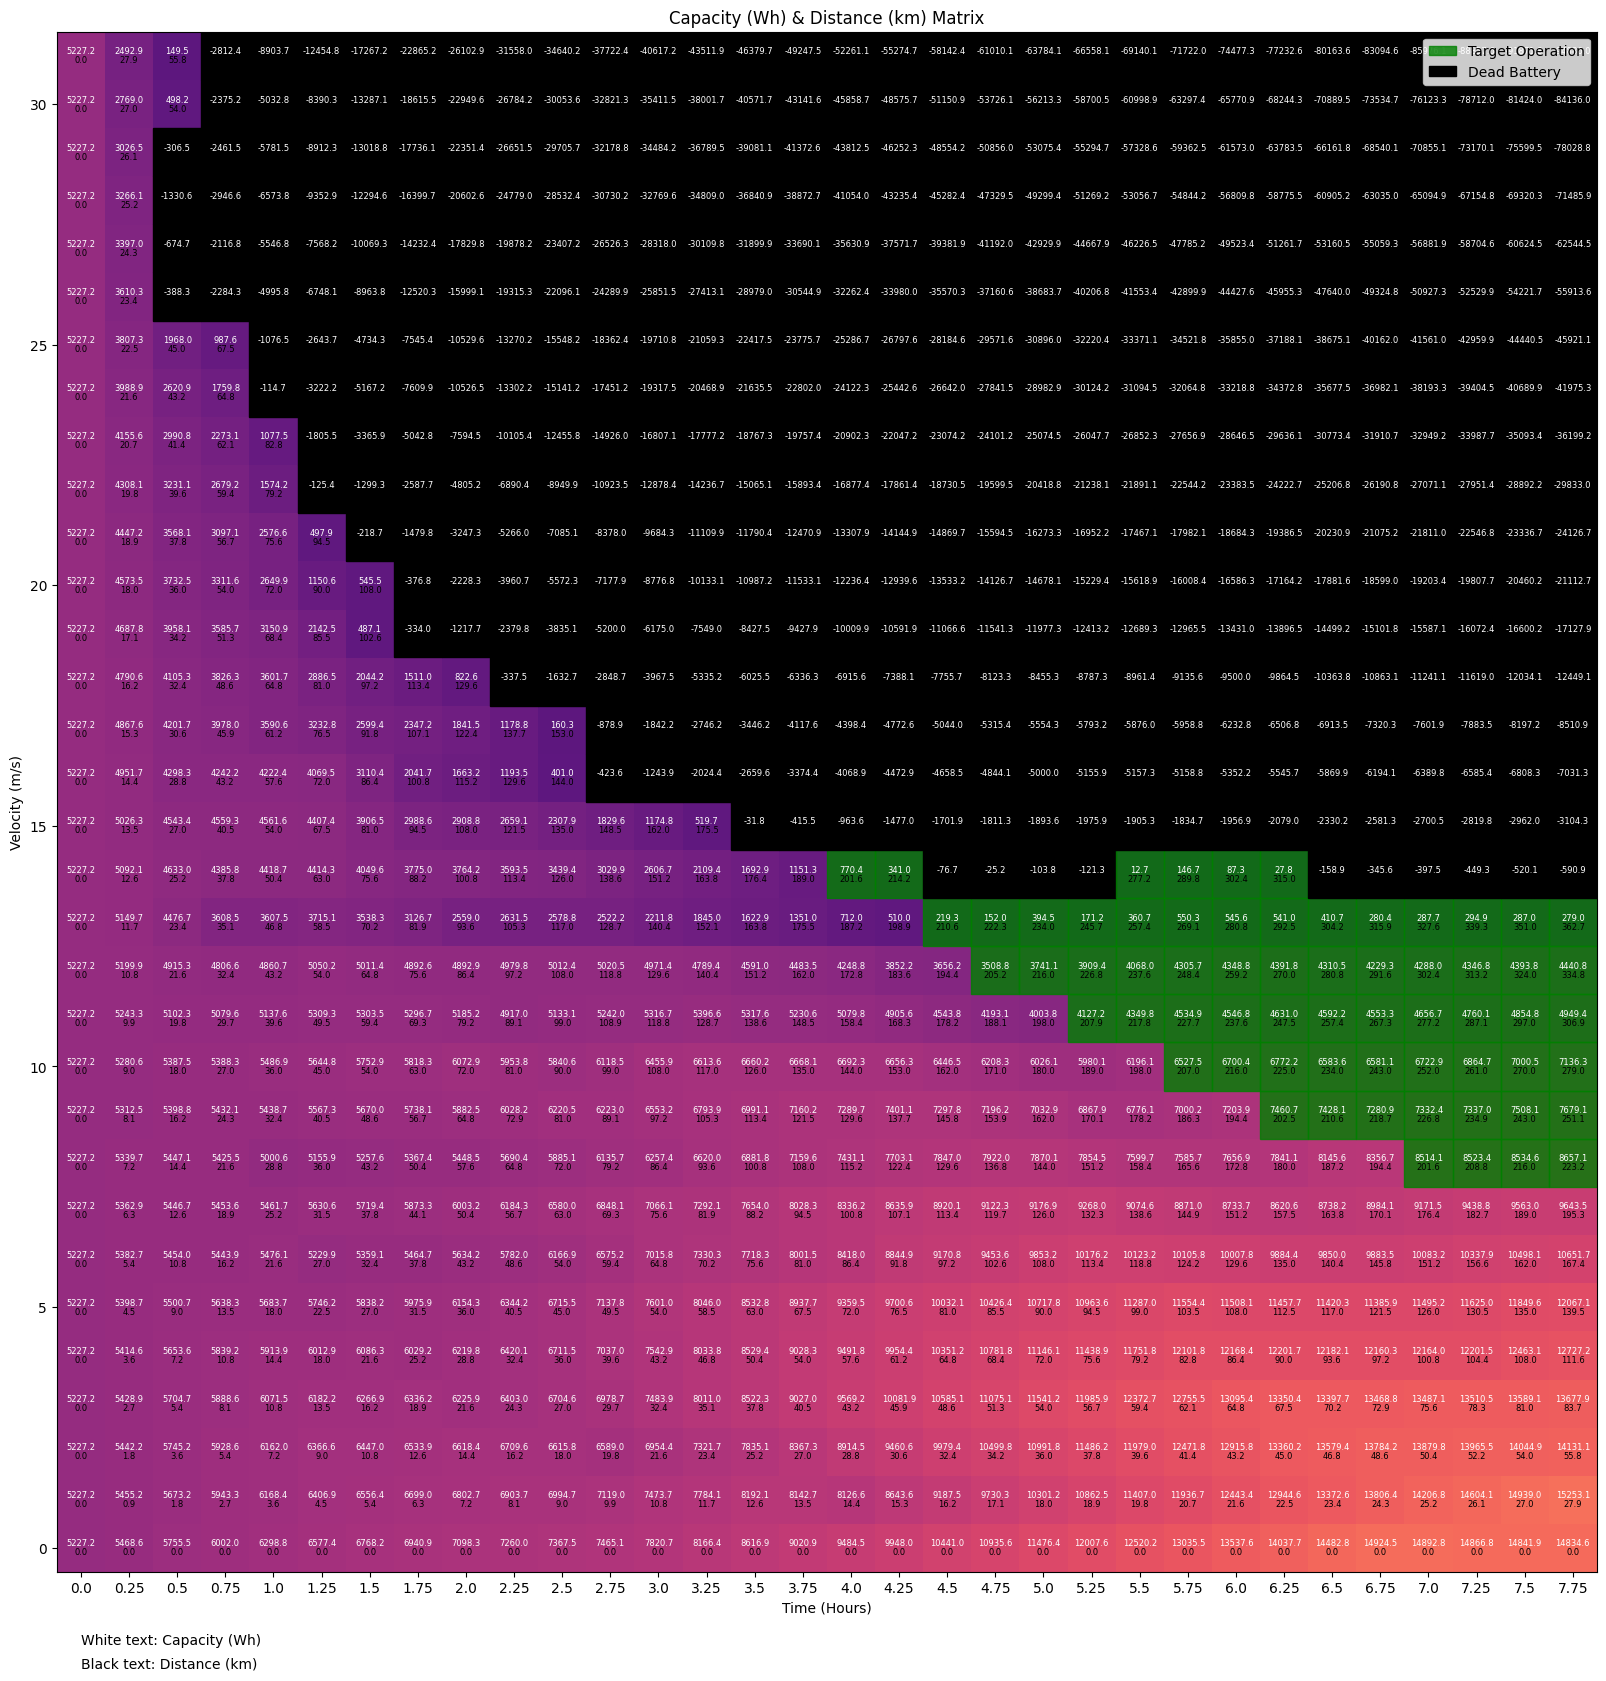

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 20))  # Width and height in inches
plt.title('Capacity (Wh) & Distance (km) Matrix')
plt.xlabel('Time (Hours)')
plt.ylabel('Velocity (m/s)')
plt.imshow(capacity_values, cmap='magma', vmin=-10000, vmax=26000)
ax = plt.gca()

for (i, j), val in np.ndenumerate(capacity_values):
    if i * j * 0.9 > 200 and val > 0:
        rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='green', alpha=0.8)
        ax.add_patch(rect)
    if val < 0:
        rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='black', alpha=1)
        ax.add_patch(rect)
    plt.text(j, i, f'{val:.1f}', ha='center', va='bottom', color='white', fontsize=6)
    plt.text(j, i, f'{i * j * 0.9:.1f}', ha='center', va='top', color='black', fontsize=6)  # Product value

plt.xticks(ticks=np.arange(0, capacity_values.shape[1]), labels=[f'{i / 4}' for i in range(capacity_values.shape[1])])
plt.text(0, -2.5, 'Black text: Distance (km)', color='black', fontsize=10)
plt.text(0, -2, 'White text: Capacity (Wh)', color='black', fontsize=10)
plt.gca().invert_yaxis()

# Adding legend
legend_patches = [
    plt.Rectangle((0, 0), 1, 1, color='green', alpha=0.8, label='Target Operation'),
    plt.Rectangle((0, 0), 1, 1, color='black', alpha=1, label='Dead Battery')
]
plt.legend(handles=legend_patches, loc='upper right', fontsize=10)

plt.show()


### Velocity Specific

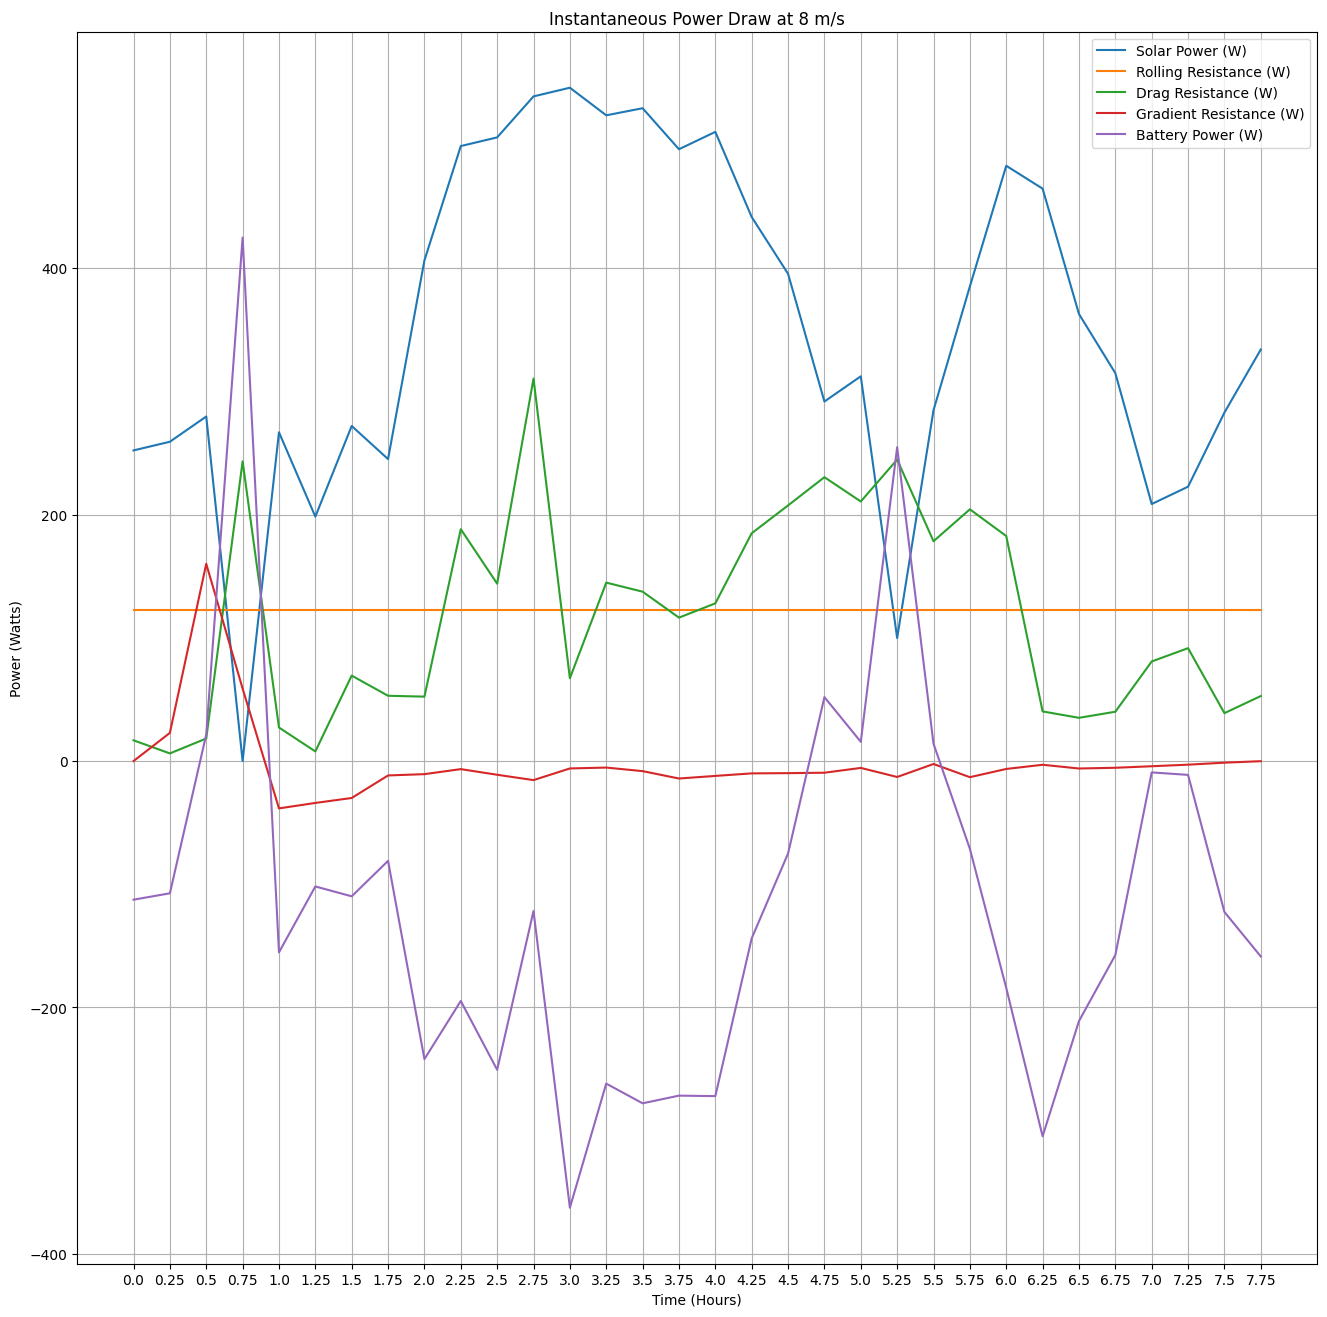

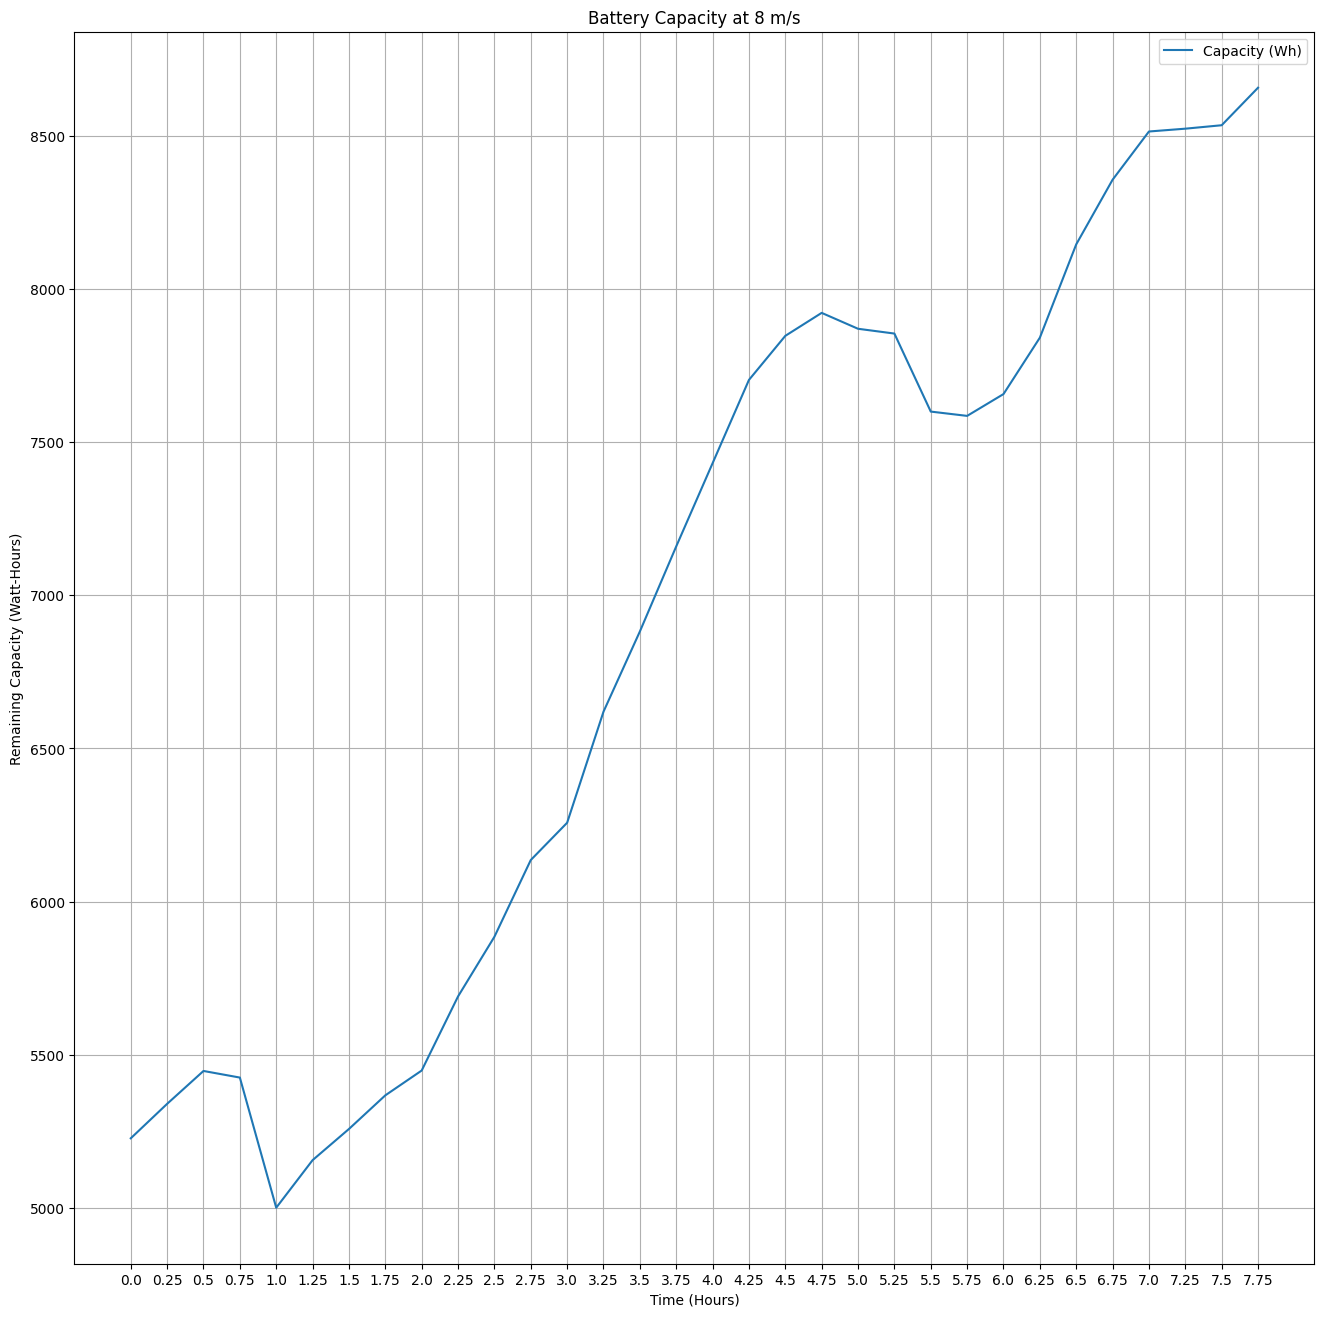

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_power_profiles(velocity, plot_solar=True, plot_rolling=True, plot_drag=True, plot_gradient=True, plot_consumed=True):
    plt.figure(figsize=(16, 16))
    
    if plot_solar:
        plt.plot(solar_power_values[velocity, :], label='Solar Power (W)')
    if plot_rolling:
        plt.plot(rolling_resistance_values[velocity, :], label='Rolling Resistance (W)')
    if plot_drag:
        plt.plot(drag_resistance_values[velocity, :], label='Drag Resistance (W)')
    if plot_gradient:
        plt.plot(gradient_resistance_values[velocity, :], label='Gradient Resistance (W)')
    if plot_consumed:
        plt.plot(energy_consumed[velocity, :], label='Battery Power (W)')
    
    plt.xlabel('Time (Hours)')
    plt.ylabel('Power (Watts)')
    plt.title(f'Instantaneous Power Draw at {velocity} m/s')
    plt.xticks(ticks=np.arange(0, capacity_values.shape[1]), labels=[f'{i/4}' for i in range(capacity_values.shape[1])])
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_capacity(velocity):
    plt.figure(figsize=(16, 16))
    plt.plot(capacity_values[velocity, :], label='Capacity (Wh)')
    plt.xlabel('Time (Hours)')
    plt.ylabel('Remaining Capacity (Watt-Hours)')
    plt.title(f'Battery Capacity at {velocity} m/s')
    plt.xticks(ticks=np.arange(0, capacity_values.shape[1]), labels=[f'{i/4}' for i in range(capacity_values.shape[1])])
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
velocity = 8

# Plot power profiles with options to toggle plots
plot_power_profiles(velocity, plot_solar=True, plot_rolling=True, plot_drag=True, plot_gradient=True, plot_consumed=True)

# Plot battery capacity
plot_capacity(velocity)


## FAQ